In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split 
import matplotlib.pyplot as plt
import random
import gc

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [25]:
gc.collect()
torch.cuda.empty_cache()

In [26]:
# foo = torch.tensor([1,2,3])
# foo = foo.to('cuda')

## Load Dataset

In [27]:
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')
train_csv.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
print(f'Missing values - train.csv \n{train_csv.isnull().sum()}\n')
print(f'Missing values - test.csv \n{test_csv.isnull().sum()}')

Missing values - train.csv 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values - test.csv 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## Clean data

In [29]:
def clean(csv_data):
    csv_data = csv_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
    cols = ['Age', 'Fare']
    for col in cols:
        csv_data[col].fillna(csv_data[col].median(), inplace = True)
        
    csv_data.Embarked.fillna('U', inplace = True)
    return csv_data

train_clean = clean(train_csv)
test_clean = clean(test_csv)

In [30]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

cols = ['Sex', 'Embarked']

for col in cols:
    train_clean[col] = le.fit_transform(train_clean[col])
    test_clean[col] = le.transform(test_clean[col])

In [31]:
print(train_clean.shape)
train_clean.head()

(891, 8)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


## Selecting Independent & Dependent features

In [32]:
X_np = train_clean.drop('Survived', axis = 1).values.astype(np.float32)
y_np = train_clean['Survived'].values.astype(np.float32)

In [33]:
X = torch.from_numpy(X_np)
y = torch.from_numpy(y_np)

In [34]:
# X = train_csv.drop('Survived', axis = 1)
# y = train_csv['Survived']

## Defining transforms

In [35]:
# transform = transforms.Compose([transforms.ToTensor()])

## Creating Custom dataset

In [36]:
class dataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
        
    def __len__(self):
        return (len(self.X))
        
    def __getitem__(self, i):
        data = self.X[i, :]
        
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data     
        
# class dataset(Dataset):
#     def __init__(self, X, y=None, transforms=None):
#         self.X = X
#         self.y = y
#         self.transforms = transforms
        
#     def __len__(self):
#         return (len(self.X))
        
#     def __getitem__(self, i):
#         data = self.X.iloc[i, :]
#         #data = np.asarray(data).astype(np.uint8)
#         data = np.asarray(data).astype(np.uint8).reshape(7, 1)
#         data = self.transforms(data)
        
#         if self.y is not None:
#             return (data, self.y[i])
#         else:
#             return data    

In [37]:
custom_data = dataset(X, y)
# custom_data = dataset(X, y, transform)

## Splitting the custom dataset

In [38]:
train_size = int(0.8*len(custom_data))
val_size = len(custom_data) - train_size

train_data, val_data = random_split(custom_data,[train_size, val_size])

## Creating Dataloaders

In [39]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=True)

## Defining the NN

In [40]:
class titanicNN(nn.Module):
    def __init__(self):
        super(titanicNN, self).__init__()
#         self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )
        
    def forward(self, x):
#         x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [41]:
model = titanicNN().to(device)
print(model)

titanicNN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=2, bias=True)
  )
)


## Loss Fn & Optimizers

In [42]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [43]:
correct_lst = []
loss_lst = []

In [44]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}")

In [45]:
def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    correct_lst.append(correct)
    loss_lst.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Training epochs

In [46]:
epochs = 500
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    val(val_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.984857  [    0/  712
Test Error: 
 Accuracy: 67.6%, Avg loss: 0.619339 

Epoch 2
-------------------------------
loss: 0.735308  [    0/  712
Test Error: 
 Accuracy: 68.7%, Avg loss: 0.634316 

Epoch 3
-------------------------------
loss: 0.493585  [    0/  712
Test Error: 
 Accuracy: 72.1%, Avg loss: 0.554462 

Epoch 4
-------------------------------
loss: 0.334572  [    0/  712
Test Error: 
 Accuracy: 76.0%, Avg loss: 0.519374 

Epoch 5
-------------------------------
loss: 0.406964  [    0/  712
Test Error: 
 Accuracy: 72.1%, Avg loss: 0.535021 

Epoch 6
-------------------------------
loss: 0.190458  [    0/  712
Test Error: 
 Accuracy: 69.3%, Avg loss: 0.609792 

Epoch 7
-------------------------------
loss: 0.514352  [    0/  712
Test Error: 
 Accuracy: 71.5%, Avg loss: 0.605742 

Epoch 8
-------------------------------
loss: 0.604818  [    0/  712
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.530680 

Epoch 9
------------------------

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.430339 

Epoch 69
-------------------------------
loss: 0.504692  [    0/  712
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.414713 

Epoch 70
-------------------------------
loss: 0.425143  [    0/  712
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.434060 

Epoch 71
-------------------------------
loss: 0.550397  [    0/  712
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.446630 

Epoch 72
-------------------------------
loss: 0.288007  [    0/  712
Test Error: 
 Accuracy: 79.9%, Avg loss: 0.405467 

Epoch 73
-------------------------------
loss: 0.312743  [    0/  712
Test Error: 
 Accuracy: 80.4%, Avg loss: 0.431737 

Epoch 74
-------------------------------
loss: 0.176264  [    0/  712
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.409441 

Epoch 75
-------------------------------
loss: 0.659210  [    0/  712
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.443612 

Epoch 76
-------------------------------
loss: 0.272094  [    0/  712
Test Error: 
 Accuracy: 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.424001 

Epoch 137
-------------------------------
loss: 0.526350  [    0/  712
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.447040 

Epoch 138
-------------------------------
loss: 0.308425  [    0/  712
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.469841 

Epoch 139
-------------------------------
loss: 0.346162  [    0/  712
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.418994 

Epoch 140
-------------------------------
loss: 0.305760  [    0/  712
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.413571 

Epoch 141
-------------------------------
loss: 0.286792  [    0/  712
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.399895 

Epoch 142
-------------------------------
loss: 0.746238  [    0/  712
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.395489 

Epoch 143
-------------------------------
loss: 0.180203  [    0/  712
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.451826 

Epoch 144
-------------------------------
loss: 0.433116  [    0/  712
Test Error: 
 Ac

Test Error: 
 Accuracy: 83.2%, Avg loss: 0.415166 

Epoch 204
-------------------------------
loss: 0.234874  [    0/  712
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.389668 

Epoch 205
-------------------------------
loss: 0.156965  [    0/  712
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.464078 

Epoch 206
-------------------------------
loss: 0.610018  [    0/  712
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.408463 

Epoch 207
-------------------------------
loss: 0.376249  [    0/  712
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.393163 

Epoch 208
-------------------------------
loss: 0.603323  [    0/  712
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.401718 

Epoch 209
-------------------------------
loss: 0.346634  [    0/  712
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.454088 

Epoch 210
-------------------------------
loss: 0.322983  [    0/  712
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.426547 

Epoch 211
-------------------------------
loss: 0.721640  [    0/  712
Test Error: 
 Ac

Test Error: 
 Accuracy: 84.4%, Avg loss: 0.403343 

Epoch 271
-------------------------------
loss: 0.256344  [    0/  712
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.399439 

Epoch 272
-------------------------------
loss: 0.191812  [    0/  712
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.394112 

Epoch 273
-------------------------------
loss: 0.808159  [    0/  712
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.404549 

Epoch 274
-------------------------------
loss: 0.569485  [    0/  712
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.408669 

Epoch 275
-------------------------------
loss: 0.508055  [    0/  712
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.407401 

Epoch 276
-------------------------------
loss: 0.553173  [    0/  712
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.413406 

Epoch 277
-------------------------------
loss: 0.480180  [    0/  712
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.434722 

Epoch 278
-------------------------------
loss: 0.515099  [    0/  712
Test Error: 
 Ac

Test Error: 
 Accuracy: 81.6%, Avg loss: 0.453817 

Epoch 338
-------------------------------
loss: 0.587179  [    0/  712
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.397651 

Epoch 339
-------------------------------
loss: 0.289019  [    0/  712
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.412183 

Epoch 340
-------------------------------
loss: 0.582952  [    0/  712
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.506192 

Epoch 341
-------------------------------
loss: 0.314032  [    0/  712
Test Error: 
 Accuracy: 80.4%, Avg loss: 0.451733 

Epoch 342
-------------------------------
loss: 0.792351  [    0/  712
Test Error: 
 Accuracy: 81.6%, Avg loss: 0.424456 

Epoch 343
-------------------------------
loss: 0.618123  [    0/  712
Test Error: 
 Accuracy: 79.9%, Avg loss: 0.441011 

Epoch 344
-------------------------------
loss: 0.498561  [    0/  712
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.467494 

Epoch 345
-------------------------------
loss: 0.789220  [    0/  712
Test Error: 
 Ac

Test Error: 
 Accuracy: 83.2%, Avg loss: 0.396582 

Epoch 405
-------------------------------
loss: 0.451472  [    0/  712
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.406190 

Epoch 406
-------------------------------
loss: 0.205354  [    0/  712
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.401933 

Epoch 407
-------------------------------
loss: 0.793883  [    0/  712
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.391937 

Epoch 408
-------------------------------
loss: 0.411373  [    0/  712
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.400889 

Epoch 409
-------------------------------
loss: 0.595038  [    0/  712
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.393464 

Epoch 410
-------------------------------
loss: 0.540151  [    0/  712
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.395713 

Epoch 411
-------------------------------
loss: 0.819910  [    0/  712
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.401856 

Epoch 412
-------------------------------
loss: 0.206837  [    0/  712
Test Error: 
 Ac

loss: 0.447697  [    0/  712
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.430111 

Epoch 473
-------------------------------
loss: 0.151243  [    0/  712
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.432365 

Epoch 474
-------------------------------
loss: 0.397315  [    0/  712
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.417299 

Epoch 475
-------------------------------
loss: 0.631046  [    0/  712
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.430373 

Epoch 476
-------------------------------
loss: 0.335182  [    0/  712
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.420174 

Epoch 477
-------------------------------
loss: 0.551929  [    0/  712
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.442068 

Epoch 478
-------------------------------
loss: 0.195012  [    0/  712
Test Error: 
 Accuracy: 81.6%, Avg loss: 0.434690 

Epoch 479
-------------------------------
loss: 0.464992  [    0/  712
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.420251 

Epoch 480
-------------------------------
loss: 0.303989  

Text(0.5, 0, 'Epoch')

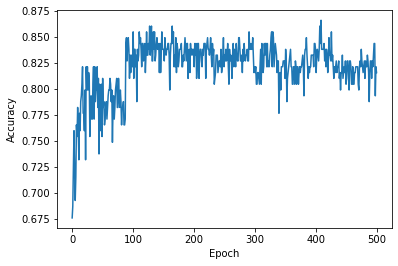

In [47]:
plt.plot(range(epochs), correct_lst)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

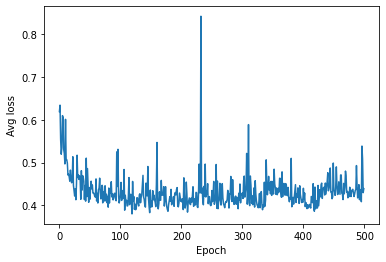

In [48]:
plt.plot(range(epochs), loss_lst)
plt.ylabel('Avg loss')
plt.xlabel('Epoch')

In [49]:
torch.save(model.state_dict(), "./model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [50]:
model = titanicNN().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [52]:
X_np = test_clean.values.astype(np.float32)
X = torch.from_numpy(X_np)

In [53]:
predicted = []
for x in X:
    x = x.to(device)
    with torch.no_grad():
        pred = model(x)
        predicted.append(pred.argmax(0).item())

In [54]:
for pred in predicted:
    print(pred)

0
0
0
0
1
0
1
0
1
0
0
0
1
0
1
1
0
0
0
1
0
0
1
0
1
0
1
0
0
0
0
0
0
1
0
0
1
1
0
0
0
0
0
1
1
0
0
0
1
1
0
0
1
1
0
0
0
0
0
1
0
0
0
1
0
1
1
0
0
1
1
0
1
0
1
0
0
1
0
1
1
0
0
0
0
0
1
1
1
0
1
0
1
0
0
0
1
0
1
0
1
0
0
0
1
0
0
0
0
0
0
1
1
1
1
0
0
1
0
1
1
0
1
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
1
0
0
1
0
0
1
1
0
1
1
1
1
0
0
1
0
0
1
1
0
0
0
0
0
1
1
0
1
1
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
0
1
0
0
1
0
1
0
0
0
0
1
0
0
1
0
1
0
1
0
1
0
1
1
0
1
0
0
0
1
0
0
0
0
0
0
1
1
1
1
0
0
0
0
1
0
1
1
1
0
0
0
0
0
0
0
1
0
0
0
1
1
0
0
0
0
1
0
0
0
1
1
0
1
0
0
0
0
1
1
1
1
1
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
1
1
0
1
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
1
0
1
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
1
0
1
0
1
0
1
1
0
0
0
1
0
1
0
0
1
0
1
1
0
1
0
0
1
1
0
0
1
0
0
1
1
0
0
0
0
0
0
1
1
0
1
0
0
0
0
0
1
0
0
0
1
0
1
0
0
1
0
1
0
0
0
0
0
1
1
1
1
1
0
1
0
0
0


In [55]:
test_ids = test_csv["PassengerId"]
submission = pd.DataFrame({
                    "PassengerId": test_ids.values, 
                    "Survived": predicted,
                  })

submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [56]:
submission.to_csv('submission.csv', index = False)